In [1]:
# Paste output from benchmark binary. This notebook parses and plots the benchmark results.
benchmark_output = '''
---------------------------------------------------------------------------------------------------------------------------
Benchmark                                                                 Time             CPU   Iterations UserCounters...
---------------------------------------------------------------------------------------------------------------------------
ScanSpeed                                                          17475638 ns     16736641 ns           39 bytes_per_second=2.91744G/s
SplitLines/strchr                                                  46517314 ns     46302067 ns           15 bytes_per_second=1079.87M/s
SplitLines/find_first_of(char)                                     35257410 ns     35219900 ns           20 bytes_per_second=1.38638G/s
SplitLines/find_first_of(str)                                      39045509 ns     38970722 ns           18 bytes_per_second=1.25294G/s
SplitLines/getline                                                219439556 ns    219265333 ns            3 bytes_per_second=228.034M/s
LineTokenize/strpbrk/space_only                                        51.6 ns         51.6 ns     13398668 bytes_per_second=776.534M/s lines_tokenized_per_second=58.1611M/s
LineTokenize/strpbrk/space_tab                                         87.5 ns         87.4 ns      8016766 bytes_per_second=458.393M/s lines_tokenized_per_second=34.3328M/s
LineTokenize/strtok/space_only                                         71.0 ns         70.9 ns      9863045 bytes_per_second=565.289M/s lines_tokenized_per_second=42.3392M/s
LineTokenize/strtok/space_tab                                           106 ns          106 ns      6651906 bytes_per_second=379.501M/s lines_tokenized_per_second=28.424M/s
IntFieldParse/from_chars                                               10.4 ns         10.4 ns     67146283 bytes_per_second=643.709M/s fields_converted_per_second=192.851M/s
IntFieldParse/atol                                                     17.5 ns         17.5 ns     40088883 bytes_per_second=382.279M/s fields_converted_per_second=114.528M/s
IntFieldParse/stoll                                                    38.9 ns         38.8 ns     18017740 bytes_per_second=171.935M/s fields_converted_per_second=51.5106M/s
IntFieldParse/strtoll                                                  19.3 ns         19.3 ns     36193480 bytes_per_second=346.183M/s fields_converted_per_second=103.714M/s
IntFieldParse/sscanf                                                   68.8 ns         68.7 ns     10221515 bytes_per_second=97.2103M/s fields_converted_per_second=29.1235M/s
IntFieldParse/istringstream                                             222 ns          222 ns      3165315 bytes_per_second=30.1327M/s fields_converted_per_second=9.02755M/s
DoubleFieldParse/from_chars(fast_float)                                19.4 ns         19.4 ns     35903144 bytes_per_second=688.216M/s fields_converted_per_second=154.639M/s
DoubleFieldParse/strtod                                                49.9 ns         49.8 ns     14128484 bytes_per_second=268.055M/s fields_converted_per_second=60.2306M/s
DoubleFieldParse/sscanf                                                 181 ns          180 ns      3872667 bytes_per_second=73.9829M/s fields_converted_per_second=16.6236M/s
DoubleFieldParse/istringstream                                          386 ns          386 ns      1818654 bytes_per_second=34.6217M/s fields_converted_per_second=7.77932M/s
LineParse/istringstream                                                 954 ns          954 ns       733169 bytes_per_second=41.9811M/s lines_parsed_per_second=3.14431M/s
LineParse/sscanf                                                        349 ns          349 ns      2001184 bytes_per_second=114.72M/s lines_parsed_per_second=8.5923M/s
LineParse/strtoll+strtod                                                108 ns          108 ns      6480641 bytes_per_second=371.375M/s lines_parsed_per_second=27.8154M/s
LineParse/from_chars+strtod/space_only                                 97.4 ns         97.3 ns      7196094 bytes_per_second=411.541M/s lines_parsed_per_second=30.8237M/s
LineParse/from_chars+strtod/space_tab                                  97.7 ns         97.6 ns      7131941 bytes_per_second=410.201M/s lines_parsed_per_second=30.7233M/s
BlockParse/scanf                                                 2994346416 ns   2992101000 ns            1 bytes_per_second=16.7107M/s
BlockParse/istringstream                                         1108316666 ns   1102376000 ns            1 bytes_per_second=45.3566M/s
BlockParse/from_chars+strtod                                      169250135 ns    169153000 ns            4 bytes_per_second=295.591M/s
BlockParse/from_chars+fast_float                                  129391125 ns    129343400 ns            5 bytes_per_second=386.568M/s
BlockParseParallel/from_chars(fast_float)/0/1/1024/real_time      543850917 ns    543523000 ns            1 bytes_per_second=367.748M/s chunk_size=1024 p=1
BlockParseParallel/from_chars(fast_float)/0/2/1024/real_time      281027271 ns    280641000 ns            2 bytes_per_second=711.675M/s chunk_size=1024 p=2
BlockParseParallel/from_chars(fast_float)/0/3/1024/real_time      195122125 ns    194564000 ns            3 bytes_per_second=1025M/s chunk_size=1024 p=3
BlockParseParallel/from_chars(fast_float)/0/4/1024/real_time      150299058 ns    149936800 ns            5 bytes_per_second=1.29949G/s chunk_size=1024 p=4
BlockParseParallel/from_chars(fast_float)/0/5/1024/real_time      122213567 ns    121683000 ns            5 bytes_per_second=1.59812G/s chunk_size=1024 p=5
BlockParseParallel/from_chars(fast_float)/0/6/1024/real_time      104158431 ns    103923167 ns            6 bytes_per_second=1.87515G/s chunk_size=1024 p=6
BlockParseParallel/from_chars(fast_float)/0/7/1024/real_time      105121965 ns     94982500 ns            6 bytes_per_second=1.85796G/s chunk_size=1024 p=7
BlockParseParallel/from_chars(fast_float)/0/8/1024/real_time      104989278 ns     85868333 ns            6 bytes_per_second=1.86031G/s chunk_size=1024 p=8
BlockParseParallel/from_chars(fast_float)/0/1/1048576/real_time   530939083 ns    530679000 ns            1 bytes_per_second=376.691M/s chunk_size=1024k p=1
BlockParseParallel/from_chars(fast_float)/0/2/1048576/real_time   268734028 ns    266605333 ns            3 bytes_per_second=744.23M/s chunk_size=1024k p=2
BlockParseParallel/from_chars(fast_float)/0/3/1048576/real_time   183362885 ns    182099750 ns            4 bytes_per_second=1090.73M/s chunk_size=1024k p=3
BlockParseParallel/from_chars(fast_float)/0/4/1048576/real_time   137157850 ns    136402400 ns            5 bytes_per_second=1.424G/s chunk_size=1024k p=4
BlockParseParallel/from_chars(fast_float)/0/5/1048576/real_time   110063868 ns    109175667 ns            6 bytes_per_second=1.77454G/s chunk_size=1024k p=5
BlockParseParallel/from_chars(fast_float)/0/6/1048576/real_time    93519667 ns     93208286 ns            7 bytes_per_second=2.08846G/s chunk_size=1024k p=6
BlockParseParallel/from_chars(fast_float)/0/7/1048576/real_time    93773464 ns     84687286 ns            7 bytes_per_second=2.08281G/s chunk_size=1024k p=7
BlockParseParallel/from_chars(fast_float)/0/8/1048576/real_time    91028089 ns     76179375 ns            8 bytes_per_second=2.14563G/s chunk_size=1024k p=8
BlockParseParallel/from_chars(fast_float)/0/1/10485760/real_time  537211958 ns    536901000 ns            1 bytes_per_second=372.293M/s chunk_size=10M p=1
BlockParseParallel/from_chars(fast_float)/0/2/10485760/real_time  268424000 ns    266212333 ns            3 bytes_per_second=745.09M/s chunk_size=10M p=2
BlockParseParallel/from_chars(fast_float)/0/3/10485760/real_time  191356906 ns    190006500 ns            4 bytes_per_second=1045.17M/s chunk_size=10M p=3
BlockParseParallel/from_chars(fast_float)/0/4/10485760/real_time  137493583 ns    136813200 ns            5 bytes_per_second=1.42052G/s chunk_size=10M p=4
BlockParseParallel/from_chars(fast_float)/0/5/10485760/real_time  110181132 ns    109899167 ns            6 bytes_per_second=1.77265G/s chunk_size=10M p=5
BlockParseParallel/from_chars(fast_float)/0/6/10485760/real_time  109270417 ns    109073167 ns            6 bytes_per_second=1.78742G/s chunk_size=10M p=6
BlockParseParallel/from_chars(fast_float)/0/7/10485760/real_time  196844750 ns    176814000 ns            4 bytes_per_second=1.98443G/s chunk_size=10M p=7
BlockParseParallel/from_chars(fast_float)/0/8/10485760/real_time  175973187 ns    150973250 ns            4 bytes_per_second=2.2198G/s chunk_size=10M p=8
BlockParseParallel/from_chars+strtod/1/1/1048576/real_time        700978000 ns    700528000 ns            1 bytes_per_second=285.316M/s chunk_size=1024k p=1
BlockParseParallel/from_chars+strtod/1/2/1048576/real_time        762650541 ns    761146000 ns            1 bytes_per_second=262.243M/s chunk_size=1024k p=2
BlockParseParallel/from_chars+strtod/1/3/1048576/real_time       1031073542 ns   1028338000 ns            1 bytes_per_second=193.973M/s chunk_size=1024k p=3
BlockParseParallel/from_chars+strtod/1/4/1048576/real_time       1501164958 ns   1455426000 ns            1 bytes_per_second=133.23M/s chunk_size=1024k p=4
BlockParseParallel/from_chars+strtod/1/5/1048576/real_time       1968180083 ns   1900277000 ns            1 bytes_per_second=101.617M/s chunk_size=1024k p=5
BlockParseParallel/from_chars+strtod/1/6/1048576/real_time       2106091333 ns   2043923000 ns            1 bytes_per_second=94.9626M/s chunk_size=1024k p=6
BlockParseParallel/from_chars+strtod/1/7/1048576/real_time       1818305875 ns   1658906000 ns            1 bytes_per_second=109.993M/s chunk_size=1024k p=7
BlockParseParallel/from_chars+strtod/1/8/1048576/real_time       1756770125 ns   1519429000 ns            1 bytes_per_second=113.845M/s chunk_size=1024k p=8
BlockParseParallel/istringstream/2/1/1048576/real_time           4450000000 ns   4447620000 ns            1 bytes_per_second=44.9438M/s chunk_size=1024k p=1
BlockParseParallel/istringstream/2/2/1048576/real_time           5591393875 ns   5579147000 ns            1 bytes_per_second=35.7693M/s chunk_size=1024k p=2
BlockParseParallel/istringstream/2/3/1048576/real_time           6957943209 ns   6952250000 ns            1 bytes_per_second=28.7441M/s chunk_size=1024k p=3
BlockParseParallel/istringstream/2/4/1048576/real_time           1.4388e+10 ns   1.4260e+10 ns            1 bytes_per_second=13.9004M/s chunk_size=1024k p=4
BlockParseParallel/istringstream/2/5/1048576/real_time           1.3733e+10 ns   1.3489e+10 ns            1 bytes_per_second=14.5635M/s chunk_size=1024k p=5
BlockParseParallel/istringstream/2/6/1048576/real_time           1.5046e+10 ns   1.5015e+10 ns            1 bytes_per_second=13.2925M/s chunk_size=1024k p=6
BlockParseParallel/istringstream/2/7/1048576/real_time           1.8981e+10 ns   1.8492e+10 ns            1 bytes_per_second=10.5371M/s chunk_size=1024k p=7
BlockParseParallel/istringstream/2/8/1048576/real_time           1.9579e+10 ns   1.8259e+10 ns            1 bytes_per_second=10.2149M/s chunk_size=1024k p=8
BlockParseParallel/scanf/3/1/1048576/real_time                   1200028333 ns   1199360000 ns            1 bytes_per_second=16.6663M/s chunk_size=1024k p=1
BlockParseParallel/scanf/3/2/1048576/real_time                   2481072334 ns   1975513000 ns            1 bytes_per_second=8.06103M/s chunk_size=1024k p=2
BlockParseParallel/scanf/3/3/1048576/real_time                   5064497750 ns   3666683000 ns            1 bytes_per_second=3.94906M/s chunk_size=1024k p=3
BlockParseParallel/scanf/3/4/1048576/real_time                   3780623166 ns   2696258000 ns            1 bytes_per_second=5.29014M/s chunk_size=1024k p=4
BlockParseParallel/scanf/3/5/1048576/real_time                   4343498292 ns   3192681000 ns            1 bytes_per_second=4.60459M/s chunk_size=1024k p=5
BlockParseParallel/scanf/3/6/1048576/real_time                   3940444458 ns   3085608000 ns            1 bytes_per_second=5.07557M/s chunk_size=1024k p=6
BlockParseParallel/scanf/3/7/1048576/real_time                   3824005583 ns   2993846000 ns            1 bytes_per_second=5.23012M/s chunk_size=1024k p=7
BlockParseParallel/scanf/3/8/1048576/real_time                   3538194500 ns   2750816000 ns            1 bytes_per_second=5.6526M/s chunk_size=1024k p=8
'''

save_images_used_in_readme = False
figure_show_mode = 'svg' # 'svg' is inline and visible in GitHub, None is native interactive plotly plots that are not visible in GitHub and several MB in size

In [2]:
def format_bytes(f: int):
    mags = {
        "B": 0,
        "KiB": 2**10,
        "MiB": 2**20,
        "GiB": 2**30,
        "TiB": 2**40,
    }
    best_unit = "B"
    for unit, multiplier in mags.items():
        if mags[best_unit] <= multiplier <= f:
            best_unit = unit

    value = f if mags[best_unit] == 0 else f/mags[best_unit]
    return f"{value:0.2g} {best_unit}"

def parse_float_with_magnitude(f: str):
    mags = {
        "K": 10**3,
        "k": 10**3,
        "M": 10**6,
        "G": 10**9,
        "T": 10**12,
    }
    mag = mags.get(f[-1], 1)
    if mag != 1:
        f = f[:-1]
    return float(f) * mag


def parse_google_benchmark_output(gbm):
    import jc

    # Add an extra space between column headers. If there's only one space then jc will parse it as one column.
    gbm = gbm.replace("Iterations UserCounters", "Iterations  UserCounters")
    res = jc.parse("asciitable", gbm, raw=True)

    for row in res:
        # Break out the benchmark variants
        bench = row["Benchmark"]
        i = bench.find("/")
        if i > 0:
            row["Group"] = bench[0:i]
            row["Variant"] = bench[i+1:]
        else:
            row["Group"] = bench

        # Parse the user counters
        if "UserCounters" in row:
            counters = row["UserCounters"].split(" ")
            for counter in counters:
                k, v = counter.split("=")
                v = v.removesuffix("/s")
                row[k] = parse_float_with_magnitude(v)
    return res


In [3]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame(parse_google_benchmark_output(benchmark_output))
df.sort_values(by='bytes_per_second', ascending=True, inplace=True)

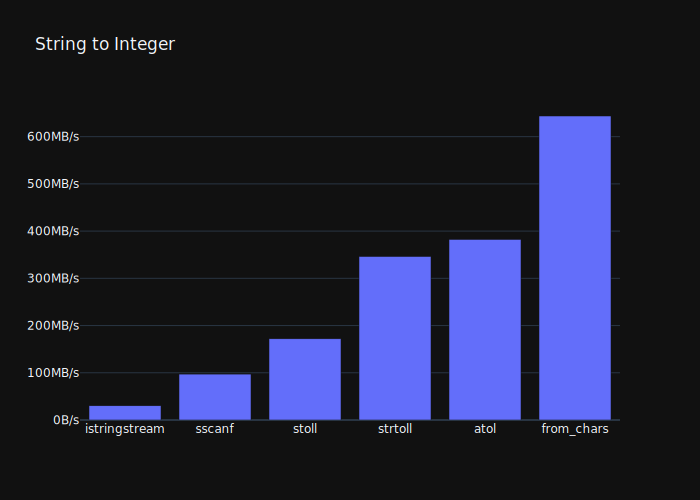

In [4]:
fig = px.bar(df[df.Group=="IntFieldParse"], x='Variant', y='bytes_per_second', title="String to Integer")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
    ),
    xaxis = dict(title=None)
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("string-to-integer.svg")

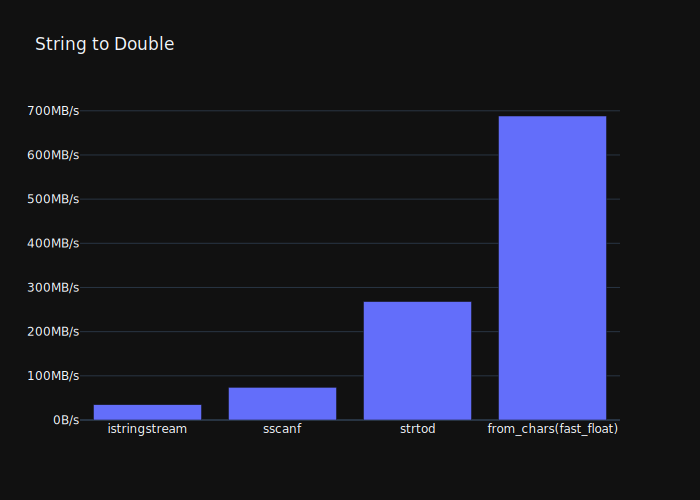

In [5]:
fig = px.bar(df[df.Group=="DoubleFieldParse"], x='Variant', y='bytes_per_second', title="String to Double")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
    ),
    xaxis = dict(title=None)
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("string-to-double.svg")

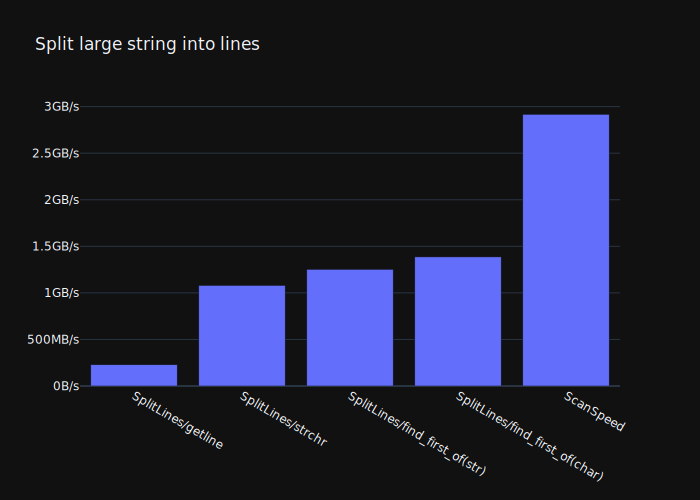

In [6]:
data = df[df["Group"].isin(["ScanSpeed", "SplitLines"])]

fig = px.bar(data, x='Benchmark', y='bytes_per_second', title="Split large string into lines")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        tickformat = '~s'
    ),
    xaxis = dict(title=None)
)
fig.show(figure_show_mode)


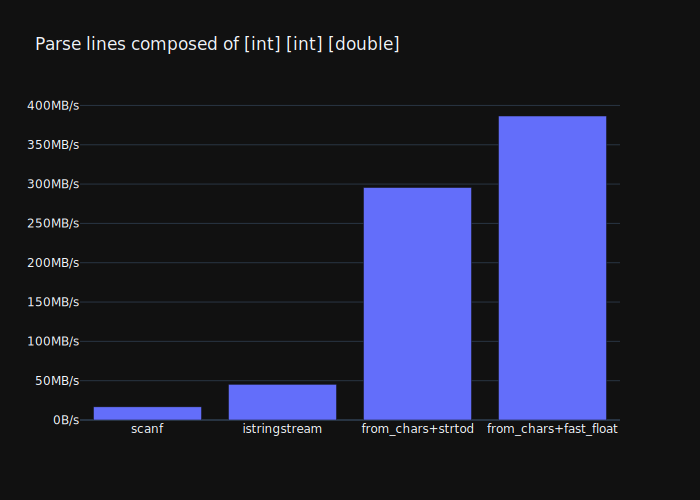

In [7]:
data = df[df["Group"].isin(["BlockParse"])]

fig = px.bar(data, x='Variant', y='bytes_per_second', title="Parse lines composed of [int] [int] [double]")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
    ),
    xaxis = dict(title=None)
)
fig.show(figure_show_mode)

In [8]:
pardata = df[df["Group"].isin(["BlockParseParallel"])].copy()
pardata["ParVariant"] = pardata["Variant"].str.split("/").str[0]
pardata["ChunkSizeInt"] = pardata["Variant"].str.split("/").str[3].astype(int)
pardata["ChunkSize"] = pardata["ChunkSizeInt"].transform(format_bytes)

pardata.sort_values(by=['ParVariant', 'p', 'ChunkSizeInt'], ascending=[True, True, False], inplace=True)

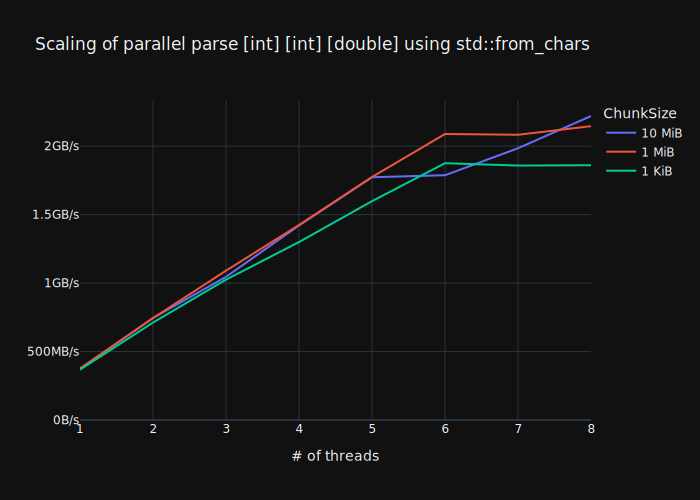

In [9]:
data = pardata[pardata["ParVariant"].isin(["from_chars(fast_float)"])]

fig = px.line(data, x='p', y='bytes_per_second', title="Scaling of parallel parse [int] [int] [double] using std::from_chars", color="ChunkSize")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        rangemode = 'tozero',
        tickformat = '~s'
    ),
    xaxis = dict(title='# of threads')
)
fig.show(figure_show_mode)

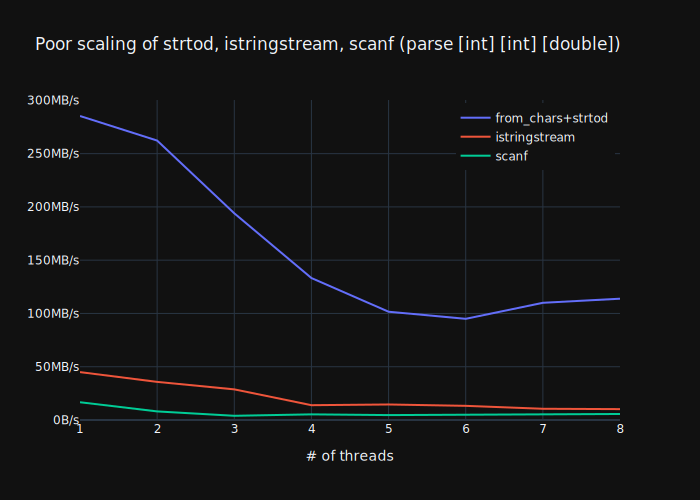

In [10]:
data = pardata[pardata["ParVariant"].isin(["from_chars+strtod", 'istringstream', 'scanf'])]

fig = px.line(data, x='p', y='bytes_per_second', title="Poor scaling of strtod, istringstream, scanf (parse [int] [int] [double])", color="ParVariant")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        rangemode = 'tozero',
        tickformat = '~s'
    ),
    xaxis = dict(title='# of threads'),
        legend=dict(
        title=None,
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ),
)
fig.show(figure_show_mode)

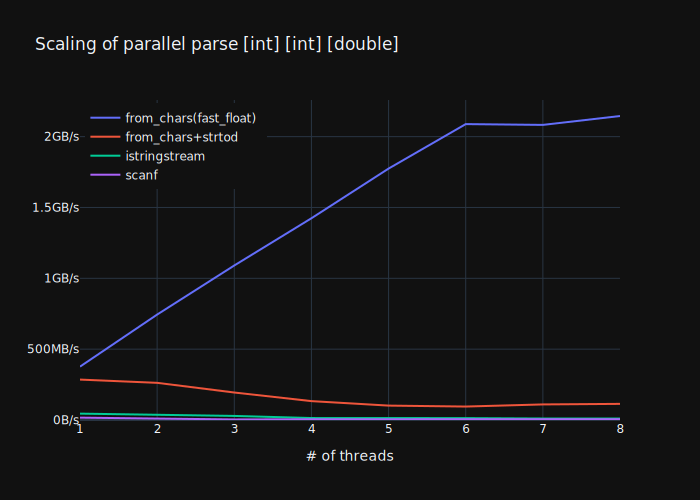

In [11]:
data = pardata[pardata["ParVariant"].isin(["from_chars(fast_float)", "from_chars+strtod", 'istringstream', 'scanf'])]
data = data[data["ChunkSize"].isin(["1 MiB"])]

fig = px.line(data, x='p', y='bytes_per_second', title="Scaling of parallel parse [int] [int] [double]", color="ParVariant")
fig.update_layout(
    yaxis = dict(
        title=None,
        ticksuffix = 'B/s',
        rangemode = 'tozero',
        tickformat = '~s'
    ),
    xaxis = dict(title='# of threads'),
    legend=dict(
        title=None,
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
)
fig.show(figure_show_mode)
if save_images_used_in_readme:
    fig.write_image("parallel-parse-scaling.svg")